# DOE 本番解析用

In [1]:
import os

import matplotlib.font_manager as fm
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import pandas as pd
import seaborn as sns
import statsmodels.api as sm
from scipy.interpolate import griddata
from statsmodels.formula.api import ols

### Matplotlib の設定（オプション）

In [2]:
FONT_PATH = "../fonts/RictyDiminished-Regular.ttf"
fm.fontManager.addfont(FONT_PATH)

# FontPropertiesオブジェクト生成（名前の取得のため）
font_prop = fm.FontProperties(fname=FONT_PATH)
font_prop.get_name()

plt.rcParams["font.family"] = font_prop.get_name()
plt.rcParams["font.size"] = 14

## CSV ファイルの読込

In [3]:
# データ読み込み
file_csv = "../logs/result_20251201162005.csv"
file_body = os.path.splitext(os.path.basename(file_csv))[0] # プロットの保存用ファイル名
df = pd.read_csv(file_csv)
df

,file,code,trade,PERIOD_MA_1,PERIOD_MA_2,PERIOD_MR,THRESHOLD_MR,total
0,ticks_20251127.xlsx,7011,100,30,300,15,1,-37.0
1,ticks_20251128.xlsx,7011,100,30,300,15,1,17.0
2,ticks_20251201.xlsx,7011,100,30,300,15,1,47.0
3,ticks_20251127.xlsx,7011,100,60,300,15,1,-68.0
4,ticks_20251128.xlsx,7011,100,60,300,15,1,-52.0
...,...,...,...,...,...,...,...,...
238,ticks_20251128.xlsx,7011,16,60,900,45,7,-3.0
239,ticks_20251201.xlsx,7011,14,60,900,45,7,20.0
240,ticks_20251127.xlsx,7011,10,90,900,45,7,-16.0
241,ticks_20251128.xlsx,7011,14,90,900,45,7,-18.0


## 分散分析 (ANOVA)

In [4]:
# オリジナルのデータフレームをコピーして利用
df_anova = df.copy()

# 因子をカテゴリ化
factor_cols = ["PERIOD_MA_1", "PERIOD_MA_2", "PERIOD_MR", "THRESHOLD_MR"]
for c in factor_cols:
    df_anova[c] = df_anova[c].astype("category")

# ANOVA（注視交互作用のみ）
formula = "total ~ C(PERIOD_MA_1)*C(PERIOD_MA_2) + C(PERIOD_MR)*C(THRESHOLD_MR)"
model = ols(formula, data=df).fit()
anova_table = sm.stats.anova_lm(model, typ=2)
print(anova_table)

                                      sum_sq     df          F        PR(>F)
C(PERIOD_MA_1)                    304.617284    2.0   0.269555  7.639641e-01
C(PERIOD_MA_2)                  21292.617284    2.0  18.841811  2.703069e-08
C(PERIOD_MR)                     4732.518519    2.0   4.187800  1.637393e-02
C(THRESHOLD_MR)                 39428.222222    2.0  34.889985  6.234240e-14
C(PERIOD_MA_1):C(PERIOD_MA_2)     743.876543    4.0   0.329128  8.582317e-01
C(PERIOD_MR):C(THRESHOLD_MR)     1484.444444    4.0   0.656792  6.226598e-01
Residual                       127698.222222  226.0        NaN           NaN


## 主効果＋交互作用 プロット

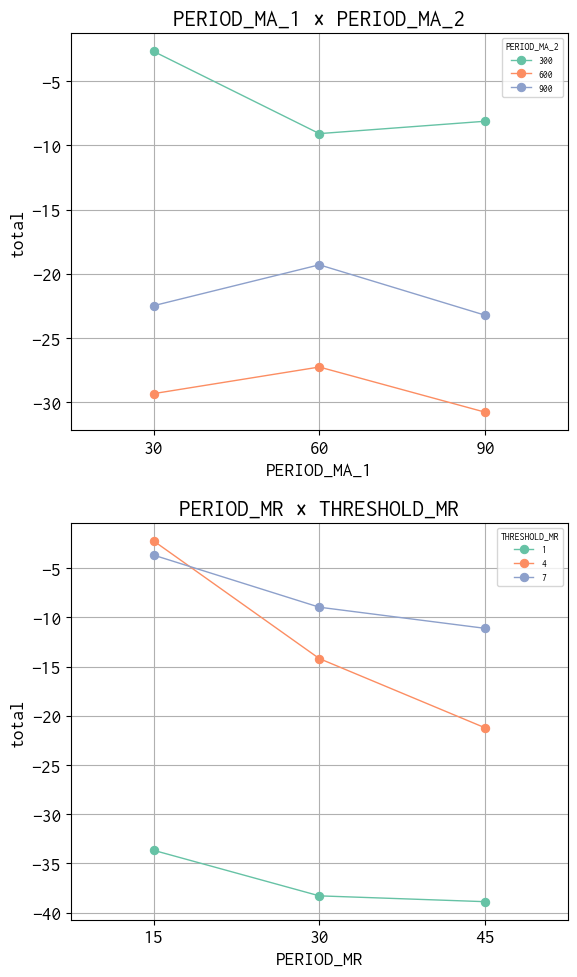

In [5]:
output = os.path.join("..", "logs", f"{file_body}_effects.png")

pairs = [
    ("PERIOD_MA_1", "PERIOD_MA_2"),
    ("PERIOD_MR", "THRESHOLD_MR"),
]

fig, axes = plt.subplots(2, 1, figsize=(6, 10))
for ax, (a, b) in zip(axes, pairs):
    sns.pointplot(
        x=a, y="total", hue=b, data=df, markersize=6, linewidth=1, errorbar=None, palette="Set2", ax=ax
    )
    ax.set_title(f"{a} × {b}")
    ax.set_xlabel(a)
    ax.set_ylabel("total")
    lg = ax.legend(fontsize=7)
    lg.set_title(b, prop={"size": 7})
    ax.grid()

plt.tight_layout()
plt.savefig(output)
plt.show()

## 交互作用の等高線図

### Contour Map

In [6]:
def plot_contour(col_x: str, col_y: str, col_z: str, output: str):
    x = df[col_x]
    y = df[col_y]
    z = df[col_z]

    # グリッド作成
    xi = np.linspace(x.min(), x.max(), 50)
    yi = np.linspace(y.min(), y.max(), 50)
    Xi, Yi = np.meshgrid(xi, yi)
    # 補間
    Zi = griddata((x, y), z, (Xi, Yi), method="cubic")

    plt.figure(figsize=(6, 6))
    cont = plt.contour(Xi, Yi, Zi, levels=15, cmap="coolwarm")
    plt.clabel(cont, inline=True, fontsize=12)
    plt.title(f"{col_x} × {col_y}")
    plt.xlabel(col_x)
    plt.ylabel(col_y)
    plt.grid(True, color="gray", linestyle="dotted", linewidth=0.5)
    plt.savefig(output)
    plt.show()

In [7]:
# ===== 1. PERIOD_MA_1 × PERIOD_MA_2 =====
output = os.path.join("..", "logs", f"{file_body}_contour_1.png")
plot_contour("PERIOD_MA_1", "PERIOD_MA_2", "total", output)
# ===== 2. PERIOD_MR × THRESHOLD_MR =====
output = os.path.join("..", "logs", f"{file_body}_contour_2.png")
plot_contour("PERIOD_MR","THRESHOLD_MR","total",output)

NameError: name 'np' is not defined